<h1><b>Movie Recommendation System Using NLP, Hybrid Filtering, and Sentiment Analysis</b></h1>


In [1]:
import pandas as pd
import spacy
import random

import matplotlib.pyplot as plt
import seaborn as sns

from spacy import displacy

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install scikit-surprise

# **Load the dataset**

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# **Read The dataset**

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# **Dataset Description**

In [5]:
def info(dataset, name):
  print("Dataset Name: ", name)
  print(f"Number of Rows: {dataset.shape[0]}")
  print(f"Number of Columns: {dataset.shape[1]}")
  print(f"Number of observations: {dataset.shape[0]*dataset.shape[1]}")
  print("Datatypes of all variables:")
  dataset.info()

In [6]:
info(movies, 'movies')

Dataset Name:  movies
Number of Rows: 62423
Number of Columns: 3
Number of observations: 187269
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
info(ratings, 'ratings')

Dataset Name:  ratings
Number of Rows: 25000095
Number of Columns: 4
Number of observations: 100000380
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


# **Combination of the dataset**

In [8]:
combined_data = pd.merge(ratings, movies, on='movieId')

In [9]:
combined_data = combined_data.iloc[0:100000]

In [10]:
# model_data.to_csv("movies-and-ratings.csv", index = False)

In [11]:
info(combined_data, 'combined_data')

Dataset Name:  combined_data
Number of Rows: 100000
Number of Columns: 6
Number of observations: 600000
Datatypes of all variables:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  int64  
 1   movieId    100000 non-null  int64  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
 4   title      100000 non-null  object 
 5   genres     100000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.3+ MB


In [12]:
combined_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


# **Check for null values in the combined dataset**

In [13]:
combined_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

# **Check data types of each column in the combined dataset**

In [14]:
combined_data.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
title         object
genres        object
dtype: object

# **Perform statistical analysis on the combined dataset**

In [15]:
combined_data.describe()

,userId,movieId,rating,timestamp
count,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,79114.723200,334.587720,4.157390,1.148640e+09
std,46791.340841,140.834929,0.959397,2.455927e+08
min,1.000000,296.000000,0.500000,8.256125e+08
25%,38608.750000,296.000000,4.000000,9.388627e+08
50%,77110.500000,296.000000,4.500000,1.127178e+09
75%,119505.500000,296.000000,5.000000,1.392872e+09
max,162541.000000,899.000000,5.000000,1.574313e+09


# **Data Visualisation**

**1. Question: What is the distribution of movie ratings?**

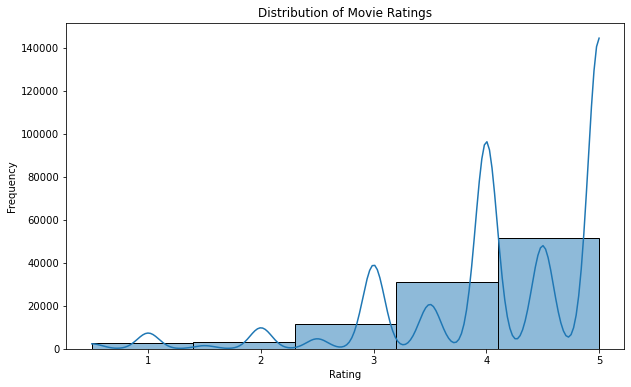

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**2. Question: How many movies are there in each genre?**

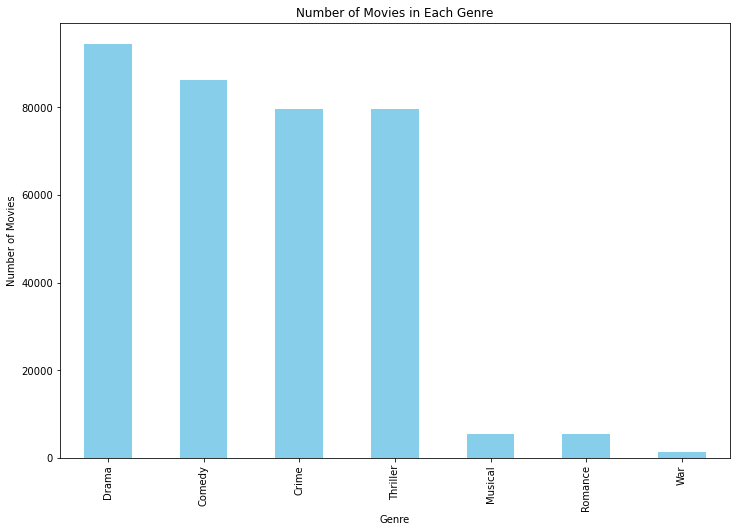

In [17]:
# Count the number of movies in each genre
genre_data = combined_data['genres'].iloc[0:100000]
genre_counts = genre_data.str.split('|', expand=True).stack().value_counts()

# Visualize the number of movies in each genre
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

**3. Question: What are the top 10 most rated movies?**

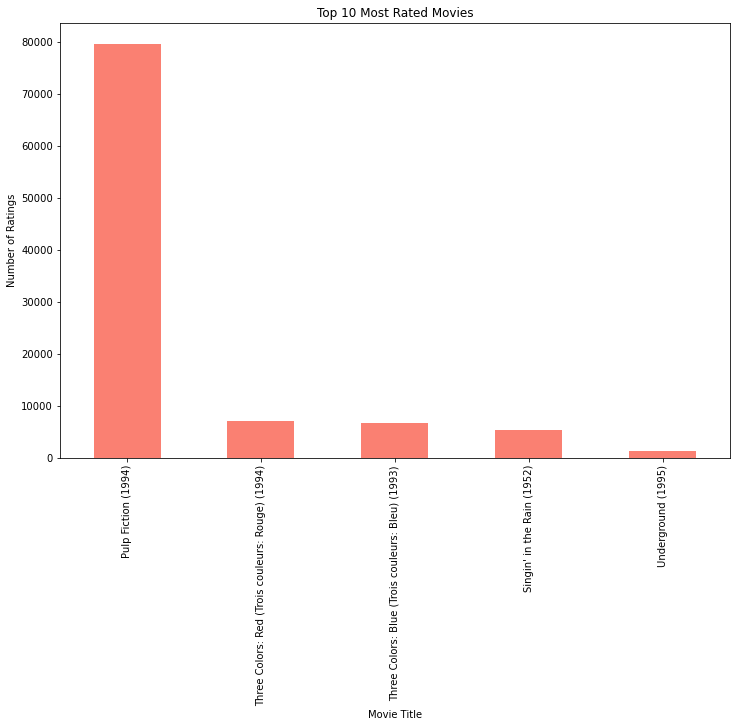

In [18]:
# Find the top 10 most rated movies
top_rated_movies = combined_data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Visualize the top 10 most rated movies
plt.figure(figsize=(12, 8))
top_rated_movies.plot(kind='bar', color='salmon')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

**4. How does the average rating vary with the number of ratings received by a movie?**

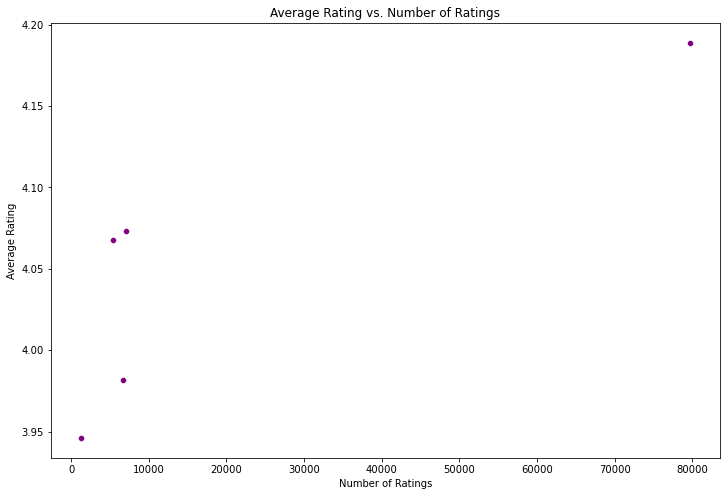

In [19]:
ratings_count = combined_data.groupby('title')['rating'].count()

avg_rating = combined_data.groupby('title')['rating'].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=ratings_count, y=avg_rating, color='purple')
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

#**Movie Reccomendation Using NLP**

In [20]:
# Data dimension reduced due to reduce runtime and nullify the issues with system memory
model_data = combined_data.iloc[65000:65010]

In [21]:
# Defining sentiment-based categories by ratings
def categorize_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating <= 2.0:
        return 'negative'
    else:
        return 'neutral'

In [22]:
# Applying sentiment categorization to ratings
ratings['sentiment'] = ratings['rating'].apply(categorize_sentiment)

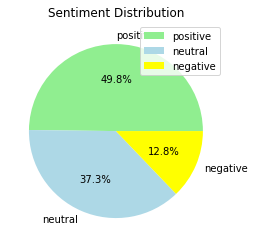

In [25]:
labels = ['positive', 'neutral', 'negative']
sizes = ratings['sentiment'].value_counts()
colors = ['lightgreen', 'lightblue', 'yellow']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
plt.gca().set_title('Sentiment Distribution')
plt.gca().legend(loc='upper right', labels=labels)
plt.gca().set_aspect('equal')

plt.show()

In [26]:
from sklearn.model_selection import train_test_split
# Feature selection for sentiment classification
train_data, test_data = train_test_split(ratings[['userId', 'movieId', 'sentiment']], test_size=0.2)

In [27]:
# Parameter grid
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [28]:
classifier = RandomForestClassifier()

In [29]:
# Performing a grid search with the defined parameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [ ]:
# Training the sentiment classifier
grid_search.fit(train_data[['userId', 'movieId']], train_data['sentiment'])

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [ ]:
# Obtaining the most suitable parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
# Training with the best model
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(train_data[['userId', 'movieId']], train_data['sentiment'])

In [ ]:
rfc_pred = best_rf_classifier.predict(test_data[['userId', 'movieId']])

In [ ]:
rfc_pred_cat = pd.DataFrame(rfc_pred).apply(lambda col:pd.Categorical(col).codes)

In [ ]:
actual_cat = pd.DataFrame(test_data['sentiment']).apply(lambda col:pd.Categorical(col).codes)

In [ ]:
print(classification_report(actual_cat, rfc_pred_cat))

In [ ]:
# Loading Surprise dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Training the collaborative filtering model
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [ ]:
# Defining the hybrid recommendation algorithm including sentiment analysis
# The hybrid filtering and the sentiment analysis feature is being embedded to the recommendation system
def hybrid_recommendation_with_sentiment(user_id, title, n=10):
    # Predicting sentiment for a target movie
    target_movie_id = movies[movies['title'] == title]['movieId'].iloc[0]
    predicted_sentiment = best_rf_classifier.predict([[user_id, target_movie_id]])[0]

    # Obtaining recommendations using the collaborative filtering mechanism
    cf_recommendations = algo.test([(user_id, target_movie_id, 4.0)])

    # Adjusting scores based on sentiment
    adjusted_scores = []
    for movie_id, _, score in cf_recommendations:
        if predicted_sentiment == 'positive':
            score += 0.1
        elif predicted_sentiment == 'negative':
            score -= 0.1
        adjusted_scores.append((movie_id, score))

    # Sorting and returning top recommendations to the calling block
    adjusted_scores.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = [(movies[movies['movieId'] == movie_id]['title'].iloc[0], score) for movie_id, score in adjusted_scores[:n]]
    return top_recommendations

In [ ]:
# Testing the modified recommendation system
user_id = random.randint(65001,65011)
user_favorite_movie = model_data['title'].loc[(user_id - 1)]
recommended_movies = hybrid_recommendation_with_sentiment(user_id, user_favorite_movie)
print("Recommended movies with sentiment adjustment:")
for movie_title, score in recommended_movies:
    print(f"Movie Title: {movie_title}, Score: {score}")